In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context("notebook")

DATA_DIR = 'data'

#### Get the data from csv files that are produced by the python scripts we run on the cluster

In [2]:
# load the mean tone a country has about itself
country_to_country_view = pd.read_csv(os.path.join(DATA_DIR, 'country_to_country_view.csv')).dropna()  # 3 rows have no mention_country
country_inner_view = pd.read_csv(os.path.join(DATA_DIR, 'country_inner_view.csv'))
country_outer_view = pd.read_csv(os.path.join(DATA_DIR, 'country_outer_view.csv'))
country_to_type_view = pd.read_csv(os.path.join(DATA_DIR, 'country_to_country_type_view.csv'))
media_to_country_view = pd.read_csv(os.path.join(DATA_DIR, 'media_to_country_view.csv'))

In [3]:
# statistical informations about the tone of the news of a country towards another
country_to_country_view.head()

,actor_country,mention_country,avg_tone,stddev_tone,count_mentions,count_events,avg_conf,avg_weighted_tone,std_weighted_tone,first_quartile_tone,median_tone,third_quartile_tone
0,Afghanistan,Botswana,-1.942005,3.236105,15,15,43.333333,-1.981697,5.082414,-3.574975,-1.971522,-0.603865
1,Albania,Jersey,-5.202312,0.000000,2,2,100.000000,-5.202312,0.000000,-5.202312,-5.202312,-5.202312
2,Albania,Kenya,-2.902415,2.918567,98,54,41.428571,-2.822658,4.137127,-5.345502,-1.954397,-0.400534
3,Antigua and Barbuda,Armenia,-7.448764,3.566137,10,6,49.000000,-7.776772,4.736934,-10.194175,-10.194175,-3.921569
4,Antigua and Barbuda,Russia,-1.930421,3.658752,81,79,45.679012,-2.430936,5.551305,-2.910855,-1.479915,0.000000


In [4]:
# statistical informations about the tone of the news of a country towards itself
country_inner_view.head()

,country,avg_tone,stddev_tone,count,avg_conf,avg_weighted_tone,std_weighted_tone,first_quartile_tone,median_tone,third_quartile_tone
0,Chad,-7.171489,4.437653,38,49.736842,-7.146625,8.970664,-7.885305,-7.604563,-6.179775
1,Anguilla,2.073790,3.367414,2242,53.617306,1.819713,4.415703,0.284900,2.410800,4.205607
2,Russia,-2.610784,3.199268,652469,37.618645,-2.573351,4.578307,-4.477612,-2.447552,-0.552486
3,Paraguay,-4.836716,0.869662,9,20.000000,-5.274985,4.752076,-4.398448,-4.398448,-4.398448
4,Yemen,-3.608844,3.585294,10106,44.735801,-3.732185,5.313685,-5.907173,-3.703704,-1.476015


In [5]:
# statistical informations about the tone of the news of the extrnal world towards a country
country_outer_view.head()

,country,avg_tone,stddev_tone,count,avg_conf,avg_weighted_tone,std_weighted_tone,first_quartile_tone,median_tone,third_quartile_tone
0,Chad,-4.413154,4.057720,283692,39.054432,-4.508526,6.295423,-7.134768,-4.258443,-1.697128
1,Anguilla,-2.637830,3.562272,6923,38.607540,-2.259031,4.967265,-5.268293,-2.945990,0.000000
2,Paraguay,-2.593173,3.223264,88008,35.508249,-2.704971,4.915539,-4.761905,-2.777778,-0.353982
3,Russia,-3.146384,2.863263,10598617,34.575652,-3.173286,4.528170,-4.912281,-3.010753,-1.288056
4,Yemen,-4.411549,2.849784,1207338,40.268889,-4.559677,5.175017,-6.219151,-4.297694,-2.665350


In [6]:
# statistical informations about the tone of the news of a country towards the type (government,
# buisnesses,...) of another country
country_to_type_view.head()

,actor_country,mention_country,actor_type,avg_tone,stddev_tone,count_mentions,count_events,avg_conf,avg_weighted_tone,std_weighted_tone,first_quartile_tone,median_tone,third_quartile_tone
0,Afghanistan,Barbados,GOV,-6.736422,3.256033,16,16,36.875000,-6.656401,6.535354,-9.271523,-9.233792,-4.612546
1,Afghanistan,China,RAD,-2.611754,1.093688,9,5,45.555556,-2.327217,1.537660,-2.247191,-2.247191,-2.247191
2,Afghanistan,Gambia,INS,-4.517831,1.231363,3,3,46.666667,-4.619392,3.767840,-5.228758,-5.228758,-3.095975
3,Afghanistan,North Korea,INS,-5.960580,3.075897,49,49,46.122449,-5.637655,4.869529,-6.572165,-6.571429,-4.852071
4,Afghanistan,Poland,UAF,2.640371,1.299043,7,2,51.428571,2.616605,1.548303,0.985222,3.050847,4.081633


In [7]:
# statistical informations about the tone of the news from a media (website) towards a country
media_to_country_view.head()

,actor_country,source_country,source_name,avg_tone,stddev_tone,count_mentions,count_events,avg_conf,avg_weighted_tone,std_weighted_tone,first_quartile_tone,median_tone,third_quartile_tone
0,Afghanistan,Australia,governmentnews.com.au,-1.318458,0.000000,1,1,50.000000,-1.318458,0.000000,-1.318458,-1.318458,-1.318458
1,Afghanistan,Austria,ots.at,5.314010,0.000000,6,6,16.666667,5.314010,3.292971,5.314010,5.314010,5.314010
2,Afghanistan,Benin,bittenus.com,1.765772,1.521576,11,10,50.909091,2.035957,1.765785,2.008032,2.012349,2.230971
3,Afghanistan,Canada,dailyheraldtribune.com,-4.650001,3.254665,13,13,54.615385,-4.562309,5.953714,-6.433824,-6.433824,-4.444444
4,Afghanistan,Canada,infotel.ca,-4.742726,3.513820,1963,1900,37.677025,-4.854639,5.871267,-6.726457,-4.341534,-2.343750


#### Compares inner and outer view in a scatterplot

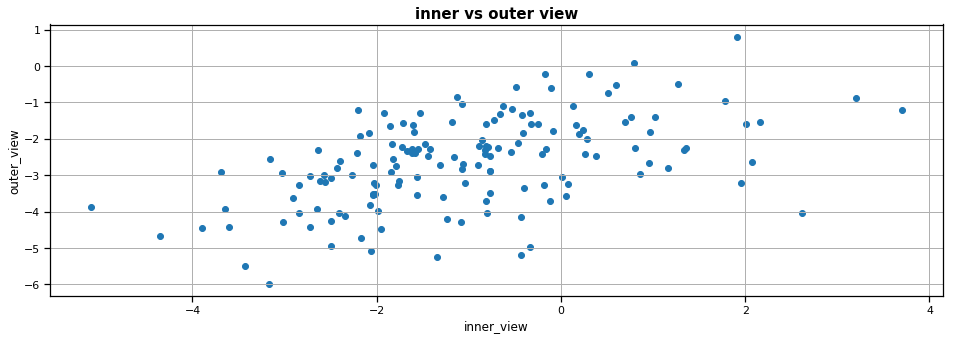

In [8]:
# comparing inner and outer view
country_inner_view = country_inner_view[country_inner_view["count"] > 1000]
country_outer_view = country_outer_view[country_outer_view["count"] > 1000]
inner_outer_view = country_inner_view.merge(country_outer_view, left_on="country", 
                                            right_on="country", suffixes=("_in", "_out"))
fig, ax = plt.subplots(figsize=(16,5))
ax.scatter(x='avg_tone_in', y='avg_tone_out', data=inner_outer_view)
ax.set_title("inner vs outer view", fontsize=15, fontweight='bold')
ax.set_ylabel('outer_view')
ax.set_xlabel('inner_view')
ax.grid(True)

#### Uses the score of a country to weight the tone its news uses when talking about another country

In [10]:
# iteratively decreasing the weight of a country with bad reputation to compute the reputation
# of another country
c_to_c_transition = country_to_country_view[["actor_country", "mention_country", "avg_tone", 
                                              "count_mentions", "avg_weighted_tone"]]
# other columns cannot be splitted from country to country

c_to_c_transition = c_to_c_transition[c_to_c_transition.actor_country !=
                                             c_to_c_transition.mention_country]


# get the count of articles for each actor_country and weight avg_tone and avg_weighted_tone by 
# this, i.e. avg_tone = avg_tone * count / (sum count for actor_country)
counts = c_to_c_transition.groupby("actor_country")["count_mentions"].agg("sum")
c_to_c_transition = c_to_c_transition.merge(counts.to_frame(), left_on="actor_country",
                                            right_on="actor_country")
c_to_c_transition.avg_tone = c_to_c_transition.avg_tone * c_to_c_transition.count_mentions_x / \
                            c_to_c_transition.count_mentions_y
c_to_c_transition.avg_weighted_tone = c_to_c_transition.avg_weighted_tone * \
                    c_to_c_transition.count_mentions_x / c_to_c_transition.count_mentions_y
c_to_c_transition = c_to_c_transition.drop(["count_mentions_x", "count_mentions_y"], axis=1)


# putting the country to country transitions in the form of a np matrix that will be more
# suitable for multiplication, we then look at real eigenvalues
index_to_country = np.unique(country_to_country_view.actor_country.values)
country_to_index = {country: index for index, country in enumerate(index_to_country)}

transition_matrix = np.zeros((index_to_country.shape[0], index_to_country.shape[0]))
for row in c_to_c_transition.itertuples(index=False):
    if row.mention_country in country_to_index:  # we do not take the country that don't have
        # mentions from other countries into account
        transition_matrix[country_to_index[row.actor_country],
                      country_to_index[row.mention_country]] = row.avg_tone

eig_val, eig_vec = np.linalg.eig(transition_matrix)
eig_vec = eig_vec[np.isreal(eig_val), :]
eig_vec = eig_vec[np.sum(np.isreal(eig_vec), 1) == 0, :]